## DETECCIÓN DE OUTLIERS POR MÉTODOS SUPERVISADOS

El objetivo del trabajo es encontrar los métodos de detección de outliers que mejor respondan a las series de tiempo que venimos analizando. Para ello se van a analizar dos modelos: support vector machine (SVM), un algoritmo de aprendizaje automático supervisado que utilizar hiperplanos en espacios multidimensionales para separar observaciones de una clase, de otras. Sin embargo, este método es utilizado además en problemas de una sola clase y está entrenado para encontrar que se etiqueta como "normal", y así poder diferenciar anomalías. Además, se utilizará el metodo de decision tree classifier. Ambos desde el paquete de sklearn.
Los métodos se consideran supervisados porque el modelo es entrenado con la etiqueta que se esta buscando predecir.

In [7]:
import numpy as np
print(f"{'numpy':<11} {np.__version__:<6}")

import pandas as pd
print(f"{'pandas':<11} {pd.__version__:<6}")

import matplotlib
print(f"{'matplotlib':<11} {matplotlib.__version__:<6}")

import matplotlib.pyplot as plt

from sklearn import __version__ as sklearn_version
print(f"{'sklearn':<11} {sklearn_version:<6}")

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, recall_score

import itertools

numpy       1.19.2
pandas      1.2.4 
matplotlib  3.3.2 
sklearn     0.24.2


In [8]:
from sklearn import set_config
set_config(display="diagram")

En esta sección se desarrolla una función que imprime un reporte de los resultados del modelo

In [9]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

def print_report( Y_test, Y_preds ):
    print('MAE                                         : %.3f'% mean_absolute_error(Y_test, Y_preds))
    print('Precision                                   : %.3f'% precision_score(Y_test, Y_preds))
    print('Recall                                      : %.3f'% recall_score(Y_test, Y_preds))
    print('F1-Score                                    : %.3f'% f1_score(Y_test, Y_preds))
    print('\nPrecision Recall F1-Score Support Per Class : \n', precision_recall_fscore_support(Y_test, Y_preds))
    print('\nClassification Report                       : ')
    print(classification_report(Y_test, Y_preds))

Asimismo se configura la matriz de confusión con la que se analizará el problema

In [10]:
# Model Evaluation
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot( Y_test, Y_preds ):

    conf_mat = confusion_matrix(Y_test, Y_preds)
    print(conf_mat)
    with plt.style.context(('ggplot', 'seaborn')):
        fig = plt.figure(figsize=(6,6), num=1)
        plt.imshow(conf_mat, interpolation='nearest',cmap= plt.cm.Blues )
        plt.xticks([0,1],[0,1])
        plt.yticks([0,1],[0,1])
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
                    plt.text(j, i,conf_mat[i, j], horizontalalignment="center",color="red")
        plt.grid(None)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.show()

In [11]:
# Data Loading
df0: pd.DataFrame = pd.read_csv(
    "traffic_AR_CL_UY+features+column_classifier.csv",
    parse_dates=["Fecha"]
)

df0["Fecha"] = pd.to_datetime(df0["Fecha"], utc=True)


In [12]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7712 entries, 0 to 7711
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Fecha                7712 non-null   datetime64[ns, UTC]
 1   Site                 7712 non-null   object             
 2   flow                 7712 non-null   object             
 3   Device               7712 non-null   object             
 4   Loading              7712 non-null   int64              
 5   Shipping             7712 non-null   int64              
 6   Payments             7712 non-null   int64              
 7   Review               7712 non-null   int64              
 8   Congrats             7712 non-null   int64              
 9   missing              7712 non-null   bool               
 10  day_of_week          7712 non-null   int64              
 11  month                7712 non-null   int64              
 12  year                

Como en los trabajos anteriores, trabajamos solo con un subset de los datos:

In [13]:
site   = "MLA"
flow   = "direct"
device = "iOS"

result: pd.DataFrame = df0.query(
        f""" Site == "{site}" and flow == '{flow}' and Device == '{device}' """
    )


In [14]:
# Column / Feature Selection
data = result[["Fecha", "Site", "flow","Device","Loading","Shipping","Payments","Review","Congrats","TOTAL","anomaly"]]


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 7 to 7701
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Fecha     488 non-null    datetime64[ns, UTC]
 1   Site      488 non-null    object             
 2   flow      488 non-null    object             
 3   Device    488 non-null    object             
 4   Loading   488 non-null    int64              
 5   Shipping  488 non-null    int64              
 6   Payments  488 non-null    int64              
 7   Review    488 non-null    int64              
 8   Congrats  488 non-null    int64              
 9   TOTAL     488 non-null    float64            
 10  anomaly   488 non-null    bool               
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(5), object(3)
memory usage: 42.4+ KB


False    0.922131
True     0.077869
Name: anomaly, dtype: float64


<AxesSubplot:title={'center':'Classes distribution'}>

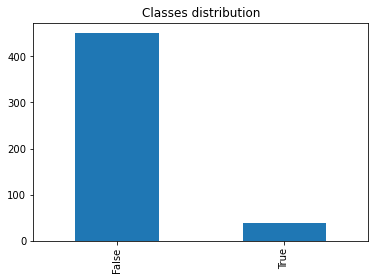

In [16]:
print(data.anomaly.value_counts(normalize=True))
data["anomaly"].value_counts().plot(kind="bar", title="Classes distribution")


Podemos ver que el dataset está desbalanceado, presentandose una relación muy desigual entre datos clasificados como outliers y datos normales (lo que no es sorprendente). Esto hace que al momento de entrenar el modelo tengamos que tener en cuenta la estratificación necesaria para que el entrenamiento sea correcto.

In [17]:
map_class = { 
    True : 1,  # Anomalies on class 1
    False: -1  # Normal on class -1
}

data["class"] = data["anomaly"].map(map_class)

target_name = "class"
target = data[target_name]
target

<ipython-input-17-5dcc771d4818>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["class"] = data["anomaly"].map(map_class)


7      -1
19     -1
31      1
43     -1
55     -1
       ..
7629    1
7647   -1
7665   -1
7683    1
7701   -1
Name: class, Length: 488, dtype: int64

In [18]:
# We drop from our data the target column to train our model
data = data.drop( columns = [ target_name , "anomaly" , "Fecha"] )
data.head()

,Site,flow,Device,Loading,Shipping,Payments,Review,Congrats,TOTAL
7,MLA,direct,iOS,29215,27378,23245,17899,16835,0.615
19,MLA,direct,iOS,22275,20572,17103,12304,11421,0.555
31,MLA,direct,iOS,18784,17220,13968,9617,8865,0.515
43,MLA,direct,iOS,24166,22199,18156,12852,11881,0.535
55,MLA,direct,iOS,29237,27081,22501,16484,15372,0.568


Generamos los datasets para los modelos

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.15, random_state=999983)

# display(X_train)
# display(y_train)

Para estructurar el tratamiento de los datos se genera un pipeline de preprocesamiento de los datos, donde se aplica OneHotEncoder a las variables categóricas y un método de imputación y de estandarización a las numéricas.

In [20]:
# define individual transformers in a pipeline
categorical_preprocessing = Pipeline([
    ('ohe', OneHotEncoder())
])
numerical_preprocessing = Pipeline([
    ('imputation', SimpleImputer()),
    ('scaler', StandardScaler())
])

# define which transformer applies to which columns
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ["Site", "flow","Device"]),
    ('numerical_preprocessing', numerical_preprocessing, ["Loading","Shipping","Payments","Review","Congrats","TOTAL"])
])

# define clasifier
#outliers_fraction = 0.09
#model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.02)

# create the final pipeline with preprocessing steps and 
# the final classifier step
#pipeline = Pipeline([
#    ('preprocess', preprocess),
#    ('clf', model )
#])

#pipeline

Probamos dos modelos buscando sus mejores hiperparámetros con gridsearch. Primero: oneclass SVM y luego decision tree classifier

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

**MODEL: ONE CLASS SVM**

In [22]:
# define clasifier
model_ocsvm = OneClassSVM()

# create the final pipeline with preprocessing steps and classifier step
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model_ocsvm )
])

parameters = {
    'clf__kernel': ["linear","poly", "rbf", "sigmoid"],
    #'clf__degree': [2, 3 , 4],
    'clf__nu': [0.001, 0.01, 0.05, 0.1, 0.5, 0.9, 0.99],
    'clf__gamma': ["scale","auto" ]
  }


PROBAMOS EL MODELO CON EL SCORING RECALL

Para encontrar la mejor combinación de hiperparámetros posible hacemos uso de Gridsearch, buscando maximizar el recall.

In [23]:
# initialize 
grid_pipeline_ocsvm_recall = GridSearchCV(pipeline,parameters, scoring="recall")
#display(pipeline.get_params().keys())
# fit
grid_pipeline_ocsvm_recall.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder())]),
                                                                         ['Site',
                                                                          'flow',
                                                                          'Device']),
                                                                        ('numerical_preprocessing',
                                                                         Pipeline(steps=[('imputation',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Loading',
                                                                          'Shipping',
                                                                          'Payments',
                                                                          'Review',
                                                                          'Congrats',
                                                                          'TOTAL'])])),
                                       ('clf', OneClassSVM())]),
             param_grid={'clf__gamma': ['scale', 'auto'],
                         'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'clf__nu': [0.001, 0.01, 0.05, 0.1, 0.5, 0.9, 0.99]},
             scoring='recall')

In [24]:
results_ocsvm_recall = grid_pipeline_ocsvm_recall.cv_results_

df_ocsvm_recall = pd.DataFrame(results_ocsvm_recall)
df_ocsvm_recall.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__gamma,param_clf__kernel,param_clf__nu,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.003571,0.007142,0.013151,0.004962,auto,poly,0.001,"{'clf__gamma': 'auto', 'clf__kernel': 'poly', ...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
36,0.005385,0.004397,0.009442,0.005061,auto,poly,0.01,"{'clf__gamma': 'auto', 'clf__kernel': 'poly', ...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
37,0.010181,0.000413,0.005585,0.000488,auto,poly,0.05,"{'clf__gamma': 'auto', 'clf__kernel': 'poly', ...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
7,0.003974,0.006053,0.009454,0.007721,scale,poly,0.001,"{'clf__gamma': 'scale', 'clf__kernel': 'poly',...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
8,0.015629,0.000017,0.000000,0.000000,scale,poly,0.01,"{'clf__gamma': 'scale', 'clf__kernel': 'poly',...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1


In [25]:
df_ocsvm_recall[['param_clf__kernel', 'param_clf__nu',"param_clf__gamma", 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head()

,param_clf__kernel,param_clf__nu,param_clf__gamma,mean_test_score,std_test_score,rank_test_score
35,poly,0.001,auto,1.0,0.0,1
36,poly,0.01,auto,1.0,0.0,1
37,poly,0.05,auto,1.0,0.0,1
7,poly,0.001,scale,1.0,0.0,1
8,poly,0.01,scale,1.0,0.0,1


In [26]:
grid_pipeline_ocsvm_recall.best_params_

{'clf__gamma': 'scale', 'clf__kernel': 'poly', 'clf__nu': 0.001}

Habiendo encontrado los mejores hiperparámetros entrenamos el modelo con los mismos y analizamos los resultados a través de una matriz de confusión


[[ 6 61]
 [ 0  7]]


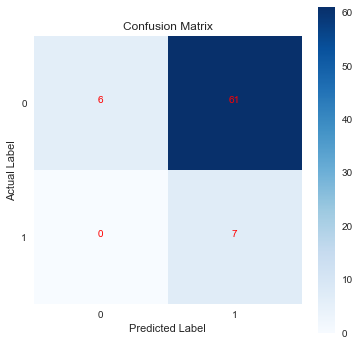

MAE                                         : 1.649
Precision                                   : 0.103
Recall                                      : 1.000
F1-Score                                    : 0.187

Precision Recall F1-Score Support Per Class : 
 (array([1.        , 0.10294118]), array([0.08955224, 1.        ]), array([0.16438356, 0.18666667]), array([67,  7], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

          -1       1.00      0.09      0.16        67
           1       0.10      1.00      0.19         7

    accuracy                           0.18        74
   macro avg       0.55      0.54      0.18        74
weighted avg       0.92      0.18      0.17        74



In [27]:
model_ocsvm_bestrecall = OneClassSVM(gamma= "scale", kernel="poly", nu=0.001) #tomamos los valores de .best_params_
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model_ocsvm_bestrecall )
])

pipeline.fit(X_train,y_train)

yhat_bestrecall = pipeline.predict(X_test)

# evaluate predictions with best parameters
confusion_matrix_plot(y_test, yhat_bestrecall)
print_report(y_test, yhat_bestrecall )


Para maximizar el recall el modelo opta por predecir todo como outlier, por lo que no tiene una buena performance. A continuación probamos maximizar el F1, que es más apropiado por ser un dataset desbalanceado.

PROBAMOS EL MODELO CON EL SCORING F1

In [28]:
# initialize 
grid_pipeline_ocsvm_f1 = GridSearchCV(pipeline,parameters, scoring="f1")
#display(pipeline.get_params().keys())
# fit
grid_pipeline_ocsvm_f1.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder())]),
                                                                         ['Site',
                                                                          'flow',
                                                                          'Device']),
                                                                        ('numerical_preprocessing',
                                                                         Pipeline(steps=[('imputation',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Loading',
                                                                          'Shipping',
                                                                          'Payments',
                                                                          'Review',
                                                                          'Congrats',
                                                                          'TOTAL'])])),
                                       ('clf',
                                        OneClassSVM(kernel='poly', nu=0.001))]),
             param_grid={'clf__gamma': ['scale', 'auto'],
                         'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'clf__nu': [0.001, 0.01, 0.05, 0.1, 0.5, 0.9, 0.99]},
             scoring='f1')

In [29]:
results_ocsvm_f1 = grid_pipeline_ocsvm_f1.cv_results_

df_ocsvm_f1 = pd.DataFrame(results_ocsvm_f1)
df_ocsvm_f1.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__gamma,param_clf__kernel,param_clf__nu,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,0.013386,0.006906,0.003126,0.006251,auto,linear,0.9,"{'clf__gamma': 'auto', 'clf__kernel': 'linear'...",0.285714,0.777778,0.333333,0.129032,0.148148,0.334801,0.234870,1
5,0.012940,0.006526,0.006685,0.007338,scale,linear,0.9,"{'clf__gamma': 'scale', 'clf__kernel': 'linear...",0.285714,0.777778,0.333333,0.129032,0.148148,0.334801,0.234870,1
34,0.009618,0.007365,0.009624,0.007870,auto,linear,0.99,"{'clf__gamma': 'auto', 'clf__kernel': 'linear'...",0.000000,0.518519,0.285714,0.285714,0.125000,0.242989,0.174661,3
6,0.016522,0.001780,0.006248,0.007652,scale,linear,0.99,"{'clf__gamma': 'scale', 'clf__kernel': 'linear...",0.000000,0.518519,0.285714,0.285714,0.125000,0.242989,0.174661,3
12,0.018201,0.004015,0.008483,0.007771,scale,poly,0.9,"{'clf__gamma': 'scale', 'clf__kernel': 'poly',...",0.307692,0.526316,0.000000,0.153846,0.222222,0.242015,0.174286,5


In [30]:
df_ocsvm_f1[['param_clf__kernel', 'param_clf__nu',"param_clf__gamma", 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head()

,param_clf__kernel,param_clf__nu,param_clf__gamma,mean_test_score,std_test_score,rank_test_score
33,linear,0.9,auto,0.334801,0.234870,1
5,linear,0.9,scale,0.334801,0.234870,1
34,linear,0.99,auto,0.242989,0.174661,3
6,linear,0.99,scale,0.242989,0.174661,3
12,poly,0.9,scale,0.242015,0.174286,5


In [31]:
grid_pipeline_ocsvm_f1.best_params_

{'clf__gamma': 'scale', 'clf__kernel': 'linear', 'clf__nu': 0.9}

[[49 18]
 [ 2  5]]


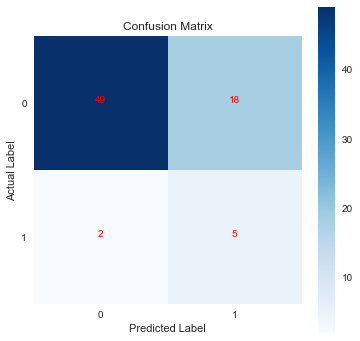

MAE                                         : 0.541
Precision                                   : 0.217
Recall                                      : 0.714
F1-Score                                    : 0.333

Precision Recall F1-Score Support Per Class : 
 (array([0.96078431, 0.2173913 ]), array([0.73134328, 0.71428571]), array([0.83050847, 0.33333333]), array([67,  7], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

          -1       0.96      0.73      0.83        67
           1       0.22      0.71      0.33         7

    accuracy                           0.73        74
   macro avg       0.59      0.72      0.58        74
weighted avg       0.89      0.73      0.78        74



In [32]:
model_ocsvm_bestf1 = OneClassSVM(gamma= "scale", kernel="linear", nu=0.9)
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model_ocsvm_bestf1 )
])

pipeline.fit(X_train,y_train)

yhat_bestf1 = pipeline.predict(X_test)

# evaluate predictions with best parameters
confusion_matrix_plot(y_test, yhat_bestf1)
print_report(y_test, yhat_bestf1 )


Podemos ver que en este caso si bien la recall cayó a 0.72, el f1 score mejoró fuertemente. 

**MODEL: DECISION TREE**
directamente con F1 dado que con recall es mucho el costo de maximizar su valor.

En esta sección vamos a probar con un modelo de árbol de decisión, para ver si conseguimos mejores resultados.

In [33]:
from sklearn.tree import DecisionTreeClassifier

# define classifier
model_dt = DecisionTreeClassifier(random_state=0)

# create the final pipeline with preprocessing steps and classifier step
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model_dt )
])

parameters = {
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': range(1,20,1),
    'clf__min_samples_leaf': range(1,10,1)
    #'clf__min_samples_split' : range(1,50,2)
}

In [34]:
# initialize 
grid_pipeline_dt_f1 = GridSearchCV(pipeline,parameters, scoring="f1")
#display(pipeline.get_params().keys())
# fit
grid_pipeline_dt_f1.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder())]),
                                                                         ['Site',
                                                                          'flow',
                                                                          'Device']),
                                                                        ('numerical_preprocessing',
                                                                         Pipeline(steps=[('imputation',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Loading',
                                                                          'Shipping',
                                                                          'Payments',
                                                                          'Review',
                                                                          'Congrats',
                                                                          'TOTAL'])])),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': range(1, 20),
                         'clf__min_samples_leaf': range(1, 10)},
             scoring='f1')

In [35]:
results_dt_f1 = grid_pipeline_dt_f1.cv_results_

df_dt_f1 = pd.DataFrame(results_dt_f1)
df_dt_f1.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
170,0.016526,0.001788,0.000000,0.000000,gini,19,9,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",0.8,1.0,1.0,0.857143,1.0,0.931429,0.085905,1
53,0.008628,0.002238,0.006095,0.004438,gini,6,9,"{'clf__criterion': 'gini', 'clf__max_depth': 6...",0.8,1.0,1.0,0.857143,1.0,0.931429,0.085905,1
62,0.010143,0.000015,0.004300,0.004604,gini,7,9,"{'clf__criterion': 'gini', 'clf__max_depth': 7...",0.8,1.0,1.0,0.857143,1.0,0.931429,0.085905,1
71,0.010138,0.000009,0.006084,0.004245,gini,8,9,"{'clf__criterion': 'gini', 'clf__max_depth': 8...",0.8,1.0,1.0,0.857143,1.0,0.931429,0.085905,1
80,0.011761,0.003626,0.004072,0.004206,gini,9,9,"{'clf__criterion': 'gini', 'clf__max_depth': 9...",0.8,1.0,1.0,0.857143,1.0,0.931429,0.085905,1


In [36]:
df_dt_f1[['param_clf__criterion', 'param_clf__max_depth',"param_clf__min_samples_leaf", 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head()

,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_leaf,mean_test_score,std_test_score,rank_test_score
170,gini,19,9,0.931429,0.085905,1
53,gini,6,9,0.931429,0.085905,1
62,gini,7,9,0.931429,0.085905,1
71,gini,8,9,0.931429,0.085905,1
80,gini,9,9,0.931429,0.085905,1


In [37]:
grid_pipeline_dt_f1.best_params_

{'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 9}

Habiendo obtenido la mejor combinación de hiperparámetros procedemos a fittear el modelo

[[65  2]
 [ 1  6]]


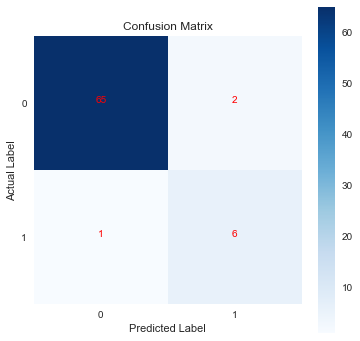

MAE                                         : 0.081
Precision                                   : 0.750
Recall                                      : 0.857
F1-Score                                    : 0.800

Precision Recall F1-Score Support Per Class : 
 (array([0.98484848, 0.75      ]), array([0.97014925, 0.85714286]), array([0.97744361, 0.8       ]), array([67,  7], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

          -1       0.98      0.97      0.98        67
           1       0.75      0.86      0.80         7

    accuracy                           0.96        74
   macro avg       0.87      0.91      0.89        74
weighted avg       0.96      0.96      0.96        74



In [38]:
model_dt_bestf1 = DecisionTreeClassifier(random_state=0, criterion= "gini", max_depth=2, min_samples_leaf=9)
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model_dt_bestf1 )
])

pipeline.fit(X_train,y_train)

yhat_bestf1 = pipeline.predict(X_test)

# evaluate predictions with best parameters
confusion_matrix_plot(y_test, yhat_bestf1)
print_report(y_test, yhat_bestf1 )


En términos generales el modelo de árbol de decisión tiene mejor resultado tanto en precision como en recall, por lo cual el F1 es superior al logrado con Support Vector Machines.
A continuación se muestran los outliers detectados en la serie temporal con este método.

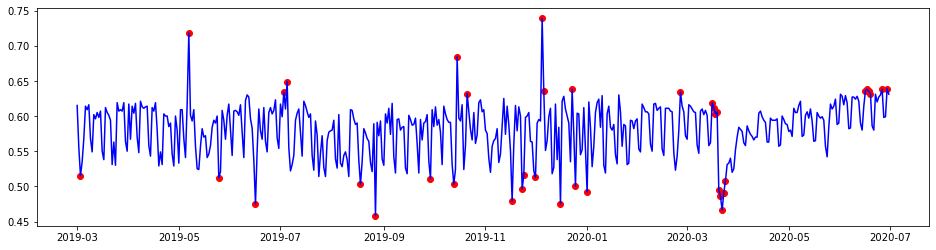

In [39]:
fig, ax = plt.subplots(figsize=(16,4))
a = result.loc[ result["anomaly"] == 1 , ["Fecha" , "TOTAL"] ] #anomaly

ax.plot(result["Fecha"], result["TOTAL"], color='blue')
ax.scatter(a["Fecha"],a["TOTAL"], color='red')

plt.show();

Como se puede observar en el gráfico, el modelo resulta bastante completo al identificar outliers. Encuentra outliers tanto por encima como por debajo de la tendencia de la serie, anticipa cambios de tendencia (pre/post-covid19) y luego encuentra una nueva normalidad solo remarcando como outliers los últimos valores de la serie.